Importing necesary libraries
- pandas - for different opeations with tables
- numpy - numeric calculations
- matplotlib and seaborn for plots
- re - regular expressions
- os - filesystem operations
- natsort - sorting of data

In [888]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from natsort import index_natsorted

Lists with group and time marks and corresponding lists of well labels

In [910]:
groups = ['Control','1_group','2_group','3_group','4_group','blank']
times = ['None','0hr','4hr','8hr','20hr','24hr','28hr','32hr','44hr','48hr']

labels_groups= [['B2','C2','D2','E2','F2','G2'],
['B3','B4','B5','B6','B7','B8','B9','B10','B11'],
['C3','C4','C5','C6','C7','C8','C9','C10','C11'],
['D3','D4','D5','D6','D7','D8','D9','D10','D11'],
['E3','E4','E5','E6','E7','E8','E9','E10','E11'],
['F3','G3']]


labels_times = [['B2','C2','D2','E2','F2','G2','F3','G3'],
['B3', 'C3', 'D3', 'E3'],
['B4', 'C4', 'D4', 'E4'],
['B5', 'C5', 'D5', 'E5'],
['B6', 'C6', 'D6', 'E6'],
['B7', 'C7', 'D7', 'E7'],
['B8', 'C8', 'D8', 'E8'],
['B9', 'C9', 'D9', 'E9'],
['B10', 'C10', 'D10', 'E10'],
['B11', 'C11', 'D11', 'E11']]

Creating some functions
- image_name_to_label - get image name as a string "_Blue_000_B10." and extract well label (B10) with help of regexp
- image_label_to_group and image_label_to_time functions map labels (B10) to list and return group (1group) and time (44h)

In [909]:

def image_name_to_label(image_path):
    image_name = os.path.basename(image_path)
    image_name_str = str(image_name)
    well_name_re = re.search(r'([B-G]\d{1,2})',image_name_str)

    return well_name_re[0]

def image_label_to_group(well_label):
    for i,group in enumerate(labels_groups):
        for y,value in enumerate(group):
            if well_label in value:
                index_g = i
                
    group_label = groups[index_g]

    return(group_label)

def image_label_to_time(well_label):
    for i,group in enumerate(labels_times):
        for y,value in enumerate(group):
            if well_label in value:
                index_t = i

    time_label = times[index_t]

    return(time_label)



Paths to datafiles in .csv

In [820]:
path_nuclei = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Nucleus_filtered.csv"
path_focii = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_H2AX_in_nucleus.csv"
path_focii_desc = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Masked_H2AX.csv"
path_image_data = "C:/Users/Modern/Desktop/Kirill/Counted_2/MyExpt_Image.csv"


Load .csv as pandas dataframes

In [936]:
nuclei_pd=pd.read_csv(path_nuclei)
focii_pd=pd.read_csv(path_focii)
focii_desc_pd = pd.read_csv(path_focii_desc)
image_data_pd=pd.read_csv(path_image_data)


Extract dataframes labels for convenience

In [938]:
labels_nuclei = nuclei_pd.head()
labels_focii = focii_pd.head()
labels_image_data = image_data_pd.head()
labels_path_focii_desc = focii_desc_pd.head()

# print(labels_focii)


Create dataframe with correspondence between well label, group and time

In [940]:
labels = image_data_pd['URL_Dapi'].apply(image_name_to_label)

labels_df = pd.DataFrame(labels)

well_group = labels_df['URL_Dapi'].apply(image_label_to_group)
well_time = labels_df['URL_Dapi'].apply(image_label_to_time)

labels_df["Group"] = well_group
labels_df["Time"] = well_time


labels_df = labels_df.join(image_data_pd['ImageNumber'])
labels_df = labels_df.rename(columns={'URL_Dapi':'Well_Name'})

# print(labels_df)

     Well_Name    Group  Time  ImageNumber
0          B10  1_group  44hr            1
1          B11  1_group  48hr            2
2           B2  Control  None            3
3           B3  1_group   0hr            4
4           B4  1_group   4hr            5
...        ...      ...   ...          ...
4483        E9  4_group  32hr         4484
4484        F2  Control  None         4485
4485        F3    blank  None         4486
4486        G2  Control  None         4487
4487        G3    blank  None         4488

[4488 rows x 4 columns]


Summ individual foci for each nucleus 

In [942]:
foci_image_corr = focii_desc_pd[['ImageNumber','ObjectNumber','Parent_Nucleus_filtered']].copy()
foci_data = focii_pd[['ImageNumber','ObjectNumber','Intensity_IntegratedIntensity_Red']].copy()

nuclei_pd_numbers = nuclei_pd[['ImageNumber','Children_Masked_H2AX_Count']].copy()

foci_data_image_corr = pd.merge(foci_image_corr,foci_data, how='left',
                                left_on=['ImageNumber','ObjectNumber'],right_on=['ImageNumber','ObjectNumber'])

foci_integrated_intensity_summs = foci_data_image_corr.groupby(['ImageNumber','Parent_Nucleus_filtered'])['Intensity_IntegratedIntensity_Red'].sum()


# print(foci_integrated_intensity_summs)

In [943]:
foci_data_w_labels = pd.merge(foci_integrated_intensity_summs,labels_df,how='left',
                         left_on=['ImageNumber'],right_on=['ImageNumber'])

nuclei_numbers_w_labels = pd.merge(nuclei_pd_numbers,labels_df,how='left',
                         left_on=['ImageNumber'],right_on=['ImageNumber'])


print(foci_data_w_labels)



       ImageNumber  Intensity_IntegratedIntensity_Red Well_Name    Group  Time
0                2                          17.589868       B11  1_group  48hr
1                2                         483.758117       B11  1_group  48hr
2                2                         729.378076       B11  1_group  48hr
3                3                          94.031221        B2  Control  None
4                3                          24.290654        B2  Control  None
...            ...                                ...       ...      ...   ...
15666         4482                          28.862257        E7  4_group  24hr
15667         4483                          89.875884        E8  4_group  28hr
15668         4483                         120.077029        E8  4_group  28hr
15669         4483                          76.600535        E8  4_group  28hr
15670         4483                         259.827942        E8  4_group  28hr

[15671 rows x 5 columns]


Count nucleus per group and plot corresponding hystplot 

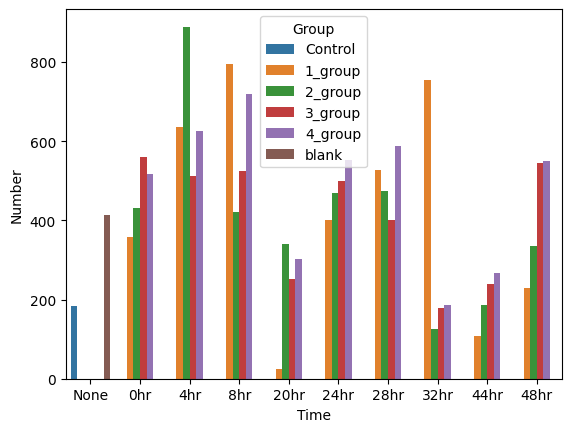

In [945]:
nucleus_count = []

for group in groups:
    for time in times:

        if (group == 'Control') or (group == 'blank'):
            time = 'None'

        count = len(nuclei_numbers_w_labels[(nuclei_numbers_w_labels['Group']==group) & (nuclei_numbers_w_labels['Time']==time) ])
        nucleus_count.append([group,time,count])


#Drop duplicates and empty values
nucleus_count_df = pd.DataFrame(nucleus_count,columns=['Group', 'Time', 'Number'])
nucleus_count_df = nucleus_count_df.drop_duplicates()
nucleus_count_df = nucleus_count_df[nucleus_count_df['Number'] != 0]

ax = sns.barplot(data=nucleus_count_df , x = nucleus_count_df['Time'], y =nucleus_count_df['Number'] , hue =nucleus_count_df['Group'] )

# print(nucleus_count_df)


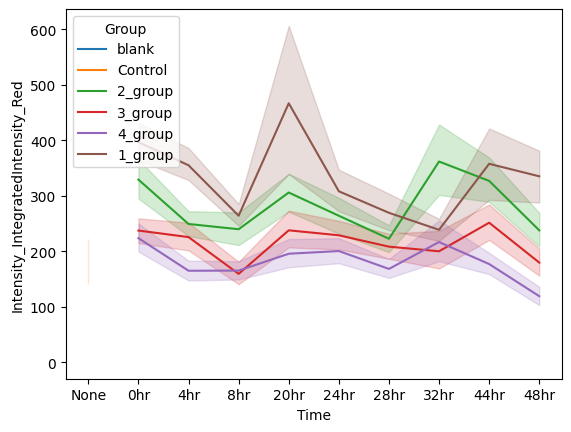

In [947]:
sorterIndex = dict(zip(times, range(len(times))))


foci_data_w_labels['Time_sort'] = foci_data_w_labels['Time'].map(sorterIndex)

foci_data_w_labels.sort_values(['Time_sort'],
        ascending = [True], inplace = True)

ax = sns.lineplot(data = foci_data_w_labels,x = 'Time',  
                  y = 'Intensity_IntegratedIntensity_Red', hue='Group')



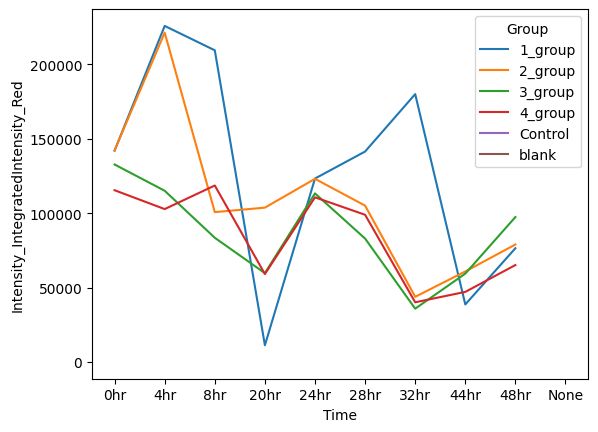

In [948]:

sums_foci_intensity = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].sum()
sums_foci_intensity_df = pd.DataFrame(sums_foci_intensity)

ax = sns.lineplot(data = sums_foci_intensity_df,x = 'Time',  
                  y = 'Intensity_IntegratedIntensity_Red', hue='Group')





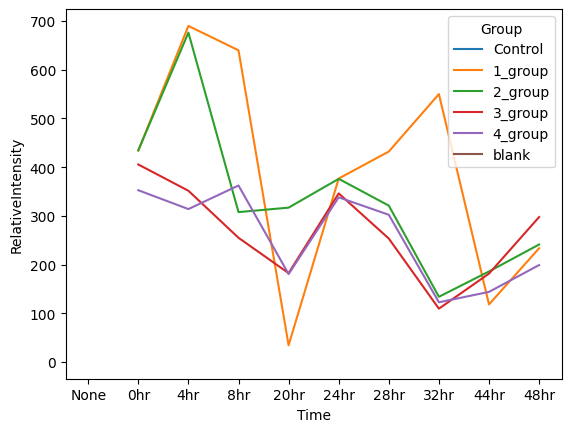

In [921]:
means_foci_intensity = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].mean()
means_foci_intensity_df = pd.DataFrame(sums_foci_intensity)
means_foci_intensity_df['STD'] = foci_data_w_labels.groupby(['Group','Time_sort','Time'])['Intensity_IntegratedIntensity_Red'].std()

foci_mean_intensity_w_nucleus_number = pd.merge(nucleus_count_df,means_foci_intensity_df,how='left',
                                left_on=['Group','Time'],right_on=['Group','Time'])

#Drop empty rows
foci_mean_intensity_w_nucleus_number = foci_mean_intensity_w_nucleus_number[foci_mean_intensity_w_nucleus_number['Number'] != 0]

foci_mean_intensity_w_nucleus_number_pd = pd.DataFrame(foci_mean_intensity_w_nucleus_number)
control_mean_instensity_df = foci_mean_intensity_w_nucleus_number_pd[foci_mean_intensity_w_nucleus_number_pd['Group'] == 'Control']

control_mean_instensity = control_mean_instensity_df.iloc[0]['Intensity_IntegratedIntensity_Red']


foci_mean_intensity_w_nucleus_number_pd['RelativeIntensity'] = foci_mean_intensity_w_nucleus_number_pd['Intensity_IntegratedIntensity_Red']/control_mean_instensity*100
foci_mean_intensity_w_nucleus_number_pd['RelativeSTD'] =  foci_mean_intensity_w_nucleus_number_pd['STD']/control_mean_instensity*100

# print(foci_mean_intensity_w_nucleus_number_pd)  

ax = sns.lineplot(data = foci_mean_intensity_w_nucleus_number,x = 'Time',  
                  y = 'RelativeIntensity', hue='Group')

# ax.set(xlabel='Time', ylabel='Relative to control intensity,%')



[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Reduced to cell count intensity,%')]

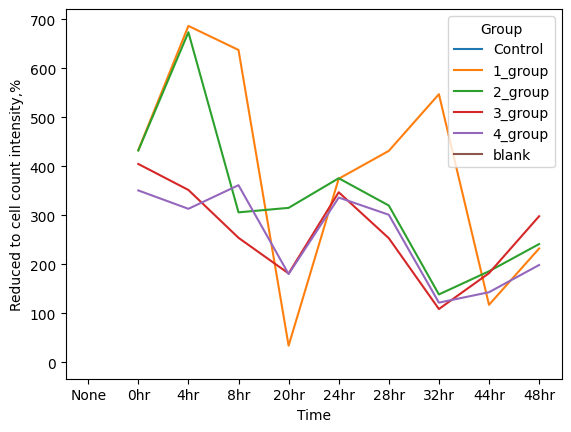

In [875]:


foci_mean_intensity_w_nucleus_number['ProductIntensity'] = foci_mean_intensity_w_nucleus_number_pd['Intensity_IntegratedIntensity_Red']*foci_mean_intensity_w_nucleus_number_pd['Number']

control_product_intensity_pd = foci_mean_intensity_w_nucleus_number[foci_mean_intensity_w_nucleus_number['Group'] == 'Control']

control_product_intensity = control_product_intensity_pd.iloc[0]['ProductIntensity']

foci_mean_intensity_w_nucleus_number['RelativeProductIntensity'] = foci_mean_intensity_w_nucleus_number['ProductIntensity'] / control_product_intensity * 100


# print(foci_mean_intensity_w_nucleus_number_pd)

# ax = sns.lineplot(data = means_foci_intensity_df,x = 'Time',  
#                   y = 'Intensity_IntegratedIntensity_Red', hue='Group')

ax = sns.lineplot(data = foci_mean_intensity_w_nucleus_number,x = 'Time',  
                  y = 'RelativeProductIntensity', hue='Group')

ax.set(xlabel='Time', ylabel='Reduced to cell count intensity,%')

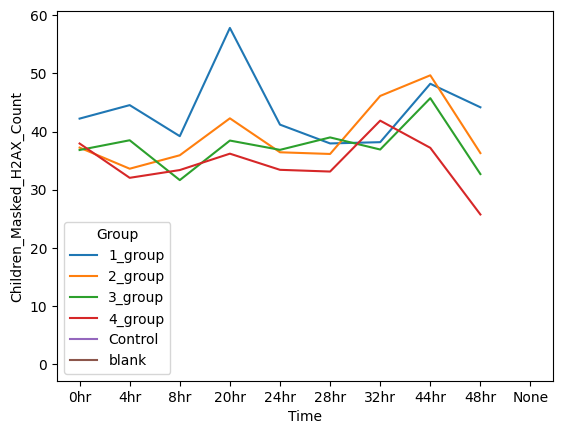

In [923]:
sorterIndex = dict(zip(times, range(len(times))))


nuclei_numbers_w_labels['Time_sort'] = nuclei_numbers_w_labels['Time'].map(sorterIndex)

nuclei_numbers_w_labels.sort_values(['Time_sort'],
        ascending = [True], inplace = True)

means_nuclei_intensity = nuclei_numbers_w_labels.groupby(['Group','Time_sort','Time'])['Children_Masked_H2AX_Count'].mean()

means_nuclei_intensity_df = pd.DataFrame(means_nuclei_intensity)


ax = sns.lineplot(data = means_nuclei_intensity_df,x = 'Time',  
                  y = 'Children_Masked_H2AX_Count', hue='Group')

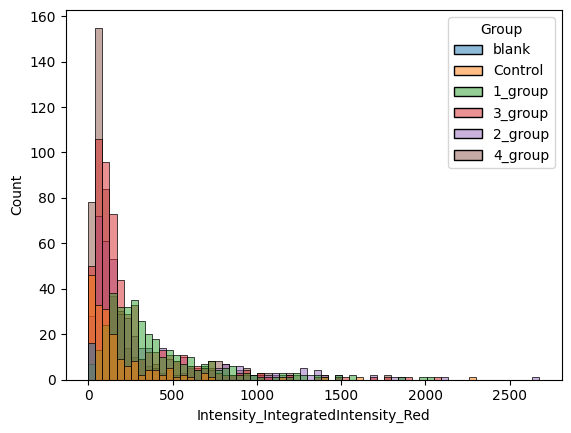

In [925]:

# rslt_df_1 = pd.DataFrame(foci_data_w_labels[(foci_data_w_labels['Group'] == "Control")])
# rslt_df_2 = pd.DataFrame(foci_data_w_labels[(foci_data_w_labels['Group'] == "1_group") & (foci_data_w_labels['Time'] == "0hr")])

# rslt_df = pd.concat([rslt_df_1,rslt_df_2])

rslt_df = foci_data_w_labels[(foci_data_w_labels['Time'] == "0hr") | (foci_data_w_labels['Time'] == "None")]


ax = sns.histplot(data=rslt_df, x=rslt_df['Intensity_IntegratedIntensity_Red'],hue='Group')


In [508]:
# rslt_df = nuclei_pd[(nuclei_pd['Group'] == "Control" ) & (nuclei_pd['Time'] == "None"   ) |
#                         (nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h")]

# rslt_df = nuclei_pd[(nuclei_pd['Time'] == "None") |(nuclei_pd['Time'] == "48_h")]
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "1_group")]

# column_sum_1 = nuclei_pd.loc[(nuclei_pd['Group']=="Control") & (nuclei_pd['Time'] == "None"),'Children_Masked_H2AX_Count'].mean()
# column_sum_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].mean()

# column_std_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].std()

# print(column_sum_2)

means = nuclei_pd['Children_Masked_H2AX_Count'].groupby(nuclei_pd['Time']).mean()
print(means)

Time
0_h     38.278908
20_h    39.637950
24_h    36.677957
28_h    36.313223
32_h    39.358521
44_h    44.163955
48_h    32.703681
4_h     36.806985
8_h     35.336316
None     9.296482
Name: Children_Masked_H2AX_Count, dtype: float64


[Text(0.5, 0, 'Number per nucleus'), Text(0, 0.5, 'Relative count')]

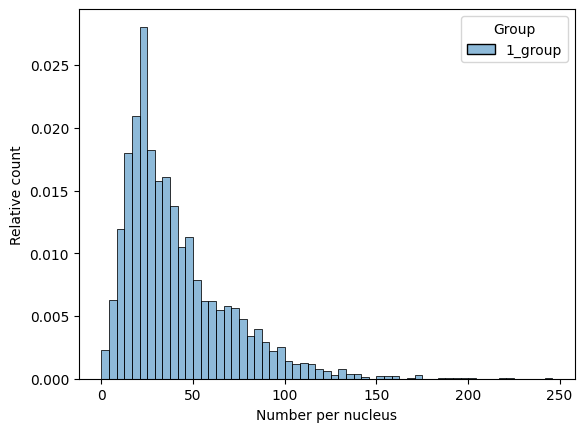

In [427]:
# stat='density' make normilized hystogramm

ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Group',stat='density')
ax.set(xlabel='Number per nucleus', ylabel='Relative count')


[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

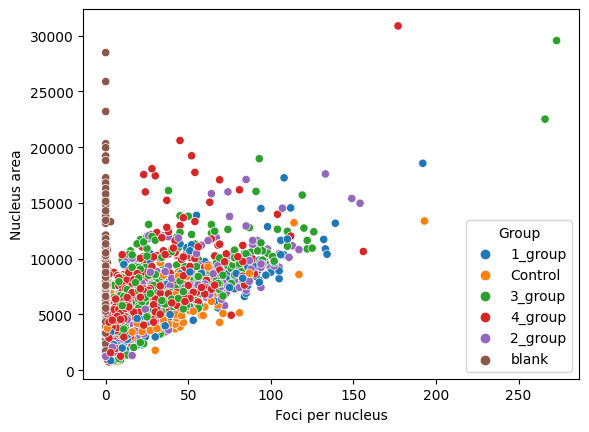

In [313]:
ax = sns.scatterplot(data=rslt_df, x = rslt_df['Children_Masked_H2AX_Count'], y = rslt_df['AreaShape_Area'],hue='Group' )
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

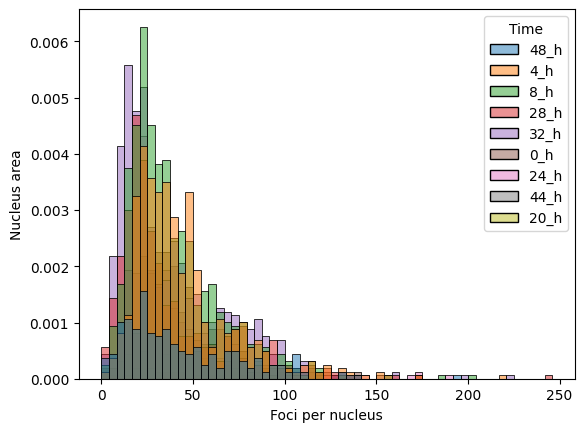

In [428]:
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "1_group")]
ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Time',stat='density')
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

In [429]:
means = nuclei_pd.groupby(['Group','Time'])['Children_Masked_H2AX_Count'].mean()
means_pd = pd.DataFrame(means)
# means_pd['Time'] =pd.Categorical(means_pd['Time'], categories = times, ordered = True )
print(means_pd)

              Children_Masked_H2AX_Count
Group   Time                            
1_group 0_h                    42.236769
        20_h                   57.833333
        24_h                   41.200000
        28_h                   37.967742
        32_h                   38.184350
        44_h                   48.231481
        48_h                   44.184211
        4_h                    44.556604
        8_h                    39.215365
2_group 0_h                    37.250000
        20_h                   42.286136
        24_h                   36.446581
        28_h                   36.156448
        32_h                   46.134921
        44_h                   49.684492
        48_h                   36.305389
        4_h                    33.619798
        8_h                    35.933333
3_group 0_h                    36.837790
        20_h                   38.462151
        24_h                   36.863727
        28_h                   39.002500
        32_h    